Required libraries:

In [1]:
import cubo
import spyndex

import xarray as xr
import numpy as np

Retrieve an AI-Focused data cube of Landsat 8 and 9:

In [3]:
da = cubo.create(
    lat=51.079225, # Central latitude of the cube
    lon=10.452173, # Central longitude of the cube
    collection="landsat-c2-l2", # Name of the STAC collection
    bands=["red","nir08"], # Bands to retrieve
    start_date="2016-06-01", # Start date of the cube
    end_date="2017-07-01", # End date of the cube
    edge_size=128, # Edge size of the cube (px)
    resolution=30, # Pixel size of the cube (m)
    query={
        "eo:cloud_cover": {"lt": 50},
        "platform": {"in": ["landsat-8", "landsat-9"]}
    }
)

/net/home/dmontero/.conda/envs/helios/lib/python3.10/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Check the cube, it is a "lazy" data cube. This means data has not been downloaded and it will be done just when data is requested.

In [4]:
da

<xarray.DataArray 'landsat-c2-l2' (time: 19, band: 2, y: 128, x: 128)>
dask.array<fetch_raster_window, shape=(19, 2, 128, 128), dtype=float64, chunksize=(1, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2016-06-06T10:08:48.89...
    id                           (time) <U31 'LC08_L2SP_194024_20160606_02_T1...
  * band                         (band) <U5 'red' 'nir08'
  * x                            (x) float64 5.998e+05 5.998e+05 ... 6.036e+05
  * y                            (y) float64 5.662e+06 5.662e+06 ... 5.658e+06
    proj:epsg                    int64 32632
    ...                           ...
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    common_name                  (band) <U5 'red' 'nir08'
    center_wavelength            (band) float64 0.65 0.87
    full_width_half_max          (band) float64 0.04 0.03
    epsg                         int64 32632
    cubo:distance_from_center    (y, x) float64 2.733e+03 ... 2.656e+03
Attributes:
    collection:           landsat-c2-l2
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 32632
    resolution:           30
    edge_size:            128
    central_lat:          51.079225
    central_lon:          10.452173
    central_y:            5659638.0946523
    central_x:            601722.4825156148
    time_coverage_start:  2016-06-01
    time_coverage_end:    2017-07-01

Request the data:

In [5]:
da = da.compute()

Plot the NIR band, just to check:

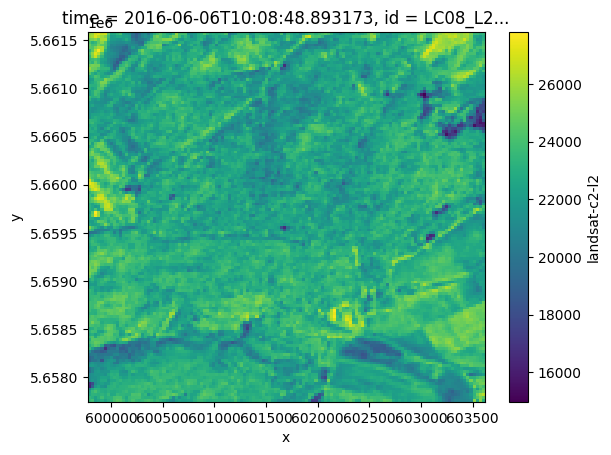

In [6]:
da.isel(time=0).sel(band="nir08").plot.imshow()

Zero should be nan:

In [7]:
da = da.where(lambda x: x != 0, other = np.nan)

Scale to [0,1]:

In [8]:
da = da*2.75e-05 - 0.2

We check the data again:

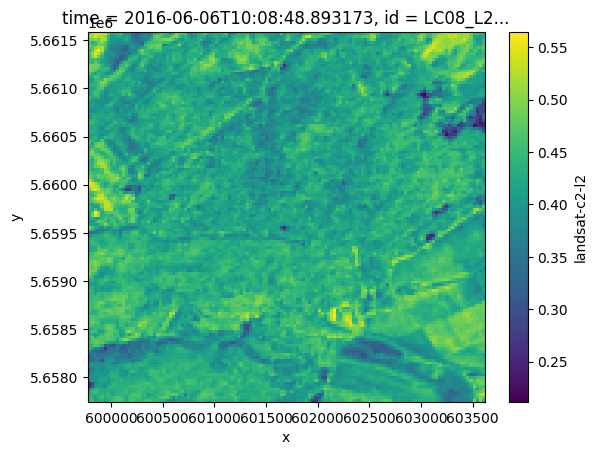

In [10]:
da.isel(time=0).sel(band="nir08").plot.imshow()

Compute spectral indices:

In [13]:
idx = spyndex.computeIndex(
    index = ["NDVI","NIRv"],
    R = da.sel(band="red"),
    N = da.sel(band="nir08"),
)

Check the cube, now it has a new dimension called index:

In [14]:
idx

<xarray.DataArray 'landsat-c2-l2' (index: 2, time: 19, y: 128, x: 128)>
array([[[[0.90642407, 0.90441023, 0.90612026, ..., 0.89999473,
          0.90041188, 0.90054307],
         [0.90745626, 0.90697055, 0.90512642, ..., 0.8937159 ,
          0.8914382 , 0.89653253],
         [0.90498585, 0.90635348, 0.90424571, ..., 0.88923084,
          0.88834015, 0.8976311 ],
         ...,
         [0.88564975, 0.88990021, 0.89142584, ..., 0.90830869,
          0.89852939, 0.90002531],
         [0.89242067, 0.89134813, 0.887472  , ..., 0.90457924,
          0.89925933, 0.89451346],
         [0.89213764, 0.89659868, 0.88640764, ..., 0.87555787,
          0.89924371, 0.88049592]],

        [[0.90598876, 0.90323694, 0.90401798, ..., 0.90132507,
          0.90234051, 0.90150483],
         [0.90896258, 0.90714784, 0.90437754, ..., 0.89479222,
          0.89407603, 0.8974592 ],
         [0.90885454, 0.9079175 , 0.90437877, ..., 0.89024726,
          0.89057517, 0.89855262],
...
         [0.02569435, 0.02365676, 0.02190795, ..., 0.04087782,
          0.03134142, 0.02370554],
         [0.02022605, 0.0189332 , 0.01782418, ..., 0.03882885,
          0.03431042, 0.03143547],
         [0.01752012, 0.01439599, 0.01596929, ..., 0.03573372,
          0.03749673, 0.03372745]],

        [[0.13541294, 0.13992071, 0.13354514, ..., 0.05245974,
          0.05246832, 0.05422496],
         [0.11869582, 0.12529733, 0.12272416, ..., 0.05384427,
          0.04548113, 0.04907247],
         [0.10961983, 0.12075261, 0.1300881 , ..., 0.05475155,
          0.0611275 , 0.07896438],
         ...,
         [0.19994151, 0.17053453, 0.16543633, ..., 0.04895124,
          0.04693997, 0.05474549],
         [0.19484862, 0.17933921, 0.17050445, ..., 0.04688405,
          0.05284672, 0.06338014],
         [0.20850075, 0.18697868, 0.17184843, ..., 0.0538861 ,
          0.06767662, 0.08568813]]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-06-06T10:08:48.893173 ... 2017-05-15T...
  * x        (x) float64 5.998e+05 5.998e+05 5.998e+05 ... 6.036e+05 6.036e+05
  * y        (y) float64 5.662e+06 5.662e+06 5.662e+06 ... 5.658e+06 5.658e+06
  * index    (index) <U4 'NDVI' 'NIRv'

Plot indices:

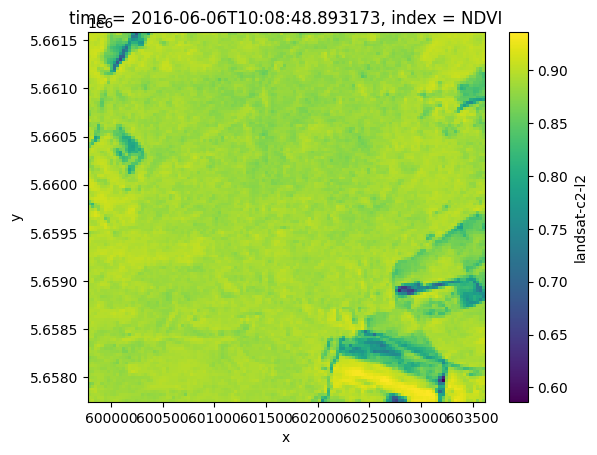

In [15]:
idx.isel(time=0).sel(index="NDVI").plot.imshow()